In [1]:
from keras import applications
import matplotlib.pyplot as plt
import os

%matplotlib inline

Using TensorFlow backend.
/Users/Gabrielle/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
pretrained_vgg_16 = applications.VGG16(weights='imagenet', include_top = True)

In [3]:
pretrained_vgg_16.layers # if I did include_top = False, this will end at MaxPooling2D, excludes the flatten and dense layers

### Build a new model with input = (input of vgg16) and output = (activations on the penultimate/2nd last layer)

In [4]:
# Get the name of the penultimate (2nd last) layer -> 'fc2'
pretrained_vgg_16.layers[-2].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc2',
 'trainable': True,
 'units': 4096,
 'use_bias': True}

In [5]:
layer_name = 'fc2'

from keras.models import Model
intermediate_layer_model = Model(inputs=pretrained_vgg_16.input,
                                 outputs=pretrained_vgg_16.get_layer('fc2').output)

### Read a new image (using cv2 or pil)

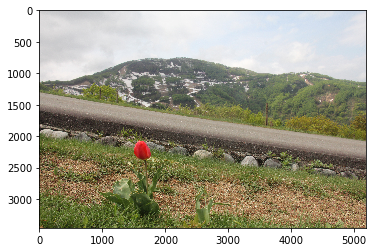

In [6]:
import cv2
img_path = '/Users/Gabrielle/Pictures/my filtered Japan photos/flowers/IMG_7572.JPG'
image = cv2.imread(img_path) # output image is blue tinted in BGR. 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
plt.imshow(image)


### Resize images, add dummy dimension

In [7]:
resized_image = cv2.resize(image, (224, 224))
resized_image.shape

(224, 224, 3)

In [8]:
# Add dummy dimension

resized_image_with_dummy_dimensions = resized_image[None, :, :, :]
resized_image_with_dummy_dimensions.shape

(1, 224, 224, 3)

### Get the feature vector for this image

In [9]:
feature_vec_my_img = intermediate_layer_model.predict(resized_image_with_dummy_dimensions)

In [10]:
feature_vec_my_img.shape

(1, 4096)

### Create album to compare my image to

In [11]:
import os
BASE_IM_DIR = '/Users/Gabrielle/Pictures/my filtered Japan photos'
album_list = os.listdir(BASE_IM_DIR)

total_im_path_list = []

# My folder structure contained images and folders containing more images. This aggregates them.
# Note that this album includes my query photo, so I expect it to return itself as its closest match.
for album_name in album_list[1:]:
    cur_album_path = os.path.join(BASE_IM_DIR, album_name)
    is_directory = os.path.isdir(cur_album_path)
    if is_directory:
        cur_im_list = os.listdir(cur_album_path)
        cur_im_list = [os.path.join(cur_album_path, im_name) for im_name in cur_im_list[1:]]
        total_im_path_list.extend(cur_im_list)
    else:
        total_im_path_list.append(cur_album_path)
len(total_im_path_list)

50

### Build feature vector list of the album

In [12]:
feature_vec_list = []
for im_ind, im_file_path in enumerate(total_im_path_list):
    if im_ind % 10 ==0:
        print (im_ind)
    # reading the image
    img = cv2.imread(im_file_path)
    # converting from bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resizing
    img = cv2.resize(img,(224,224))
    # add dummy dimension
    img = img[None]
    # extract a feature vec for each image
    feature_vec = intermediate_layer_model.predict(img)
    # cocatenating the feature vectors to one big list
    feature_vec_list.append(feature_vec.ravel())

0
10
20
30
40


### Build our kneighbors model and train it

In [13]:
# convert list into a matrix for kneighbors
import numpy as np
feature_vec_list = np.array(feature_vec_list)
feature_vec_list.shape

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)

neigh.fit(feature_vec_list)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [14]:
feature_vec_my_img

array([[ 2.74438381,  1.38153398,  1.79077864, ...,  0.        ,
         0.31944156,  0.        ]], dtype=float32)

In [15]:
distances, indices = neigh.kneighbors(feature_vec_my_img)

In [16]:
distances # Note distance of the closest image is 0, because it is itself! Success.

array([[  0.        ,  76.43281854,  79.75658223,  80.94132557,
         80.99536464,  81.5922871 ,  82.89277851,  83.02419923,
         84.97723783,  85.45771361]])

In [17]:
indices

array([[10, 24, 42, 25, 16, 18, 11,  3, 45, 44]])

Distance from query:  0.0


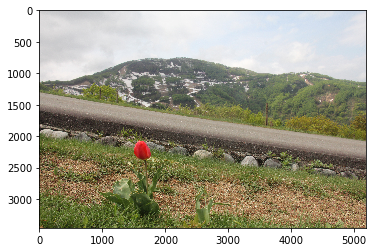

Distance from query:  76.43281853758995


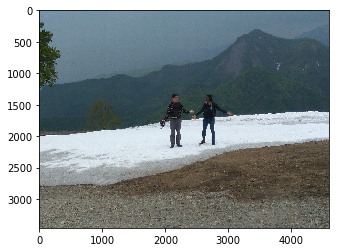

Distance from query:  79.75658223457678


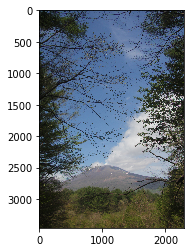

Distance from query:  80.94132557141126


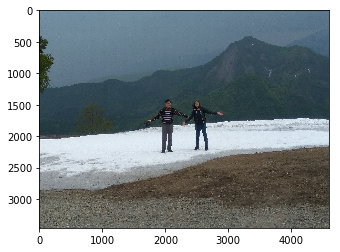

Distance from query:  80.99536464188222


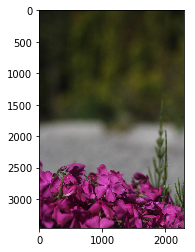

Distance from query:  81.59228710272714


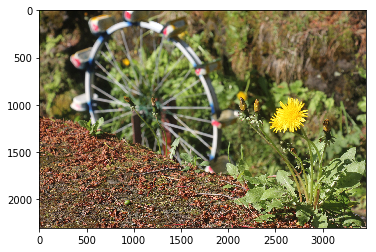

Distance from query:  82.89277851118202


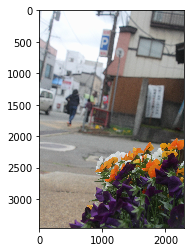

Distance from query:  83.0241992292369


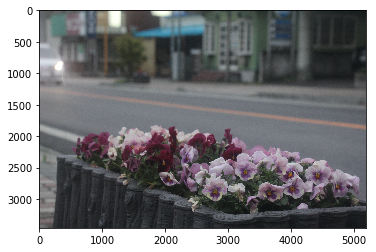

Distance from query:  84.97723783142297


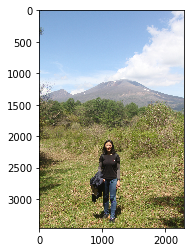

Distance from query:  85.45771360869205


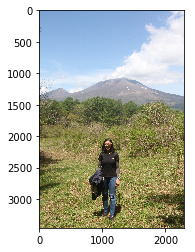

In [18]:
for distance, indice in np.nditer([distances[0] , indices[0]]):
    closest_img = total_im_path_list[indice]
    img_path = closest_img
    image = cv2.imread(img_path) # output image is blue tinted in BGR. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
    plt.imshow(image)
    print('Distance from query: ', distance)
    plt.show()

### Interesting, the nearest neighbor images include mountains and flowers. This is amidst an album of other photos of Japan (city, streets, other types of nature). So I suppose KNN here works well :)